In [1]:
from sklearn.linear_model import LinearRegression
import colour, pickle, pandas, os, sys
from scipy.stats.mstats import zscore
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from IPython.display import Markdown as md
from scipy import stats
import warnings ; warnings.filterwarnings('ignore')

In [2]:
# get parent directory containing all data 
base_directory = os.path.abspath('..')
# append to path to incorporate custom functions 
sys.path.append(base_directory) 
# import custom functions for electrophysiological data analysis
import electrophysiological.analyses as neural
# import custom functions for analyzing the retrospective dataset
import retrospective.combine_results as retrospective_analyses
# set location to save figures to 
figure_location = os.path.join(base_directory, 'summary/figures/') 
# set location of retrospective datasets and results 
retrospective_directory = os.path.join(base_directory, 'retrospective')
# import custom visualization functions for figures
import visualization_functions as viz

In [3]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


# Methods: Model Fit to Electrophysiological Data

In [4]:
# location of electrophysiological neural data from IT and V4 
vvs_data_path = os.path.join(base_directory, 'electrophysiological/ventral_neural_data.hdf5')

# compute split half reliability over n_iterations 
n_iterations = 100

# estimate split-half reliability
reliability = neural.split_half_correlation(vvs_data_path, n_iterations, np.mean)

# path to pls fitting results 
model_vvs_fits_dir = os.path.join(base_directory, 'electrophysiological/pls_fitting_results')

# extract model fits to electrophisiological data
pls_fits = neural.layer_fits(model_vvs_fits_dir, np.median, reliability)

## median split-half reliability for IT

In [5]:
md(r'$r=%.02f \pm %.02fSTD$'%(np.median(reliability['IT_NEURONS']), np.std(reliability['IT_NEURONS'])))

$r=0.73 \pm 0.24STD$

## median split-half reliability for V4

In [6]:
md(r'$r=%.02f \pm %.02fSTD$'%(np.median(reliability['V4_NEURONS']), np.std(reliability['V4_NEURONS'])))

$r=0.62 \pm 0.22STD$

### first half of model fits V4 better

In [7]:
v4_firsthalf = stats.ttest_ind(pls_fits['v4']['mu'][:len(pls_fits['it']['mu'])//2],
                               pls_fits['v4']['mu'][len(pls_fits['it']['mu'])//2:]) 

md(r'$ t( %d )=%.02f, P = %.03f$'%((len(pls_fits['v4']['mu'])//2)-1, v4_firsthalf[0],  v4_firsthalf[1]))

$ t( 8 )=2.70, P = 0.015$

### second half fits IT better

In [8]:
it_secondhalf = stats.ttest_ind(pls_fits['it']['mu'][len(pls_fits['it']['mu'])//2:], 
                                pls_fits['it']['mu'][:len(pls_fits['it']['mu'])//2]) 

md(r'$ t(%d)=%.02f, P = %.03f$'%(len(pls_fits['it']['mu'])//2-1, it_secondhalf[0], it_secondhalf[1]))

$ t(8)=3.70, P = 0.002$

### Differential model fit to IT cortex increases with layer depth

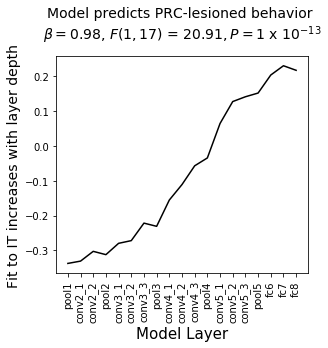

In [9]:
model_delta_fit = smf.ols('zscore(y)~zscore(x)', data=pandas.DataFrame({'y':pls_fits['delta'], 
                                                                        'x':np.arange(len(pls_fits['delta']))}))
plt.figure(figsize=[4.5, 4])
plt.plot( pls_fits['delta'], color='black') 
plt.title('Model predicts PRC-lesioned behavior \n%s'%
          viz.show_model_parameters(model_delta_fit.fit())[1], fontsize=14, y=1.05); 
plt.xlabel('Model Layer', fontsize=15)
plt.xticks(range(len(pls_fits['layers'])), pls_fits['layers'], rotation=90)
plt.ylabel('Fit to IT increases with layer depth', fontsize=14); 

## Identify 'IT-like' and 'V4-like' layers used in the retrospective dataset

In [10]:
# identify layer with the highest fit to it cortex 
it_layer = pls_fits['layers'][ pls_fits['it']['mu'].argmax() ] 

# identify layer with the highest fit to v4 cortex 
v4_layer =  pls_fits['layers'][ pls_fits['v4']['mu'].argmax() ] 

# Results 2.1: Retrospective Analysis

In [11]:
# load retrospective results -- model performance and human performance across all eligible stimuli  
retrospective = retrospective_analyses.integrate_across_studies(retrospective_directory, it_layer, v4_layer )

# compute summary statistics across retrospective results 
retrospective, meta_statistics = retrospective_analyses.summary_statistics(retrospective, it_layer, v4_layer)

# human performance for mis-classified stimuli
nondiagnostic = retrospective_analyses.non_diagnostic_stimuli() 

## 2.1.2 PRC-lesioned subjects are impaired on concurrent visual discrimination tasks

In [12]:
# test for significant difference between prc-lesioned and -intact subjects on elegable stimuli
viz.show_model_parameters( smf.ols(formula='prc_delta~1', data=retrospective).fit() )[0]

$\beta = 0.14$, $F(0, 13)$ = $2.68, P = 0.019 $

### Not a significant difference between HPC-lesioned and HPC-intact subjects

In [13]:
# test for significant difference between hpc-lesioned and -intact subjects on elegable stimuli
viz.show_model_parameters( smf.ols(formula='hpc_delta~1', data=retrospective).fit() )[0]

$\beta = 0.01$, $F(0, 13)$ = $0.73, P = 0.479 $

## 2.1.3 A computational model of the VVS approximates PRC-lesioned performance

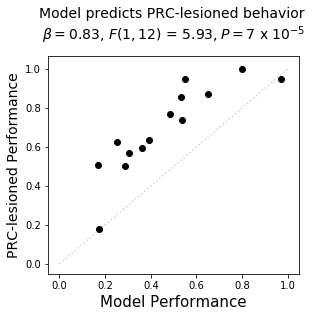

In [14]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=retrospective['prc_lesion'],x=retrospective[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
prc_itlayer_fit = smf.ols("prc_lesion ~ %s"%it_layer, retrospective).fit()
plt.title('Model predicts PRC-lesioned behavior \n%s'%
          viz.show_model_parameters(prc_itlayer_fit)[1], 
          fontsize=14, y=1.05); 
plt.xlabel('Model Performance', fontsize=15)
plt.ylabel('PRC-lesioned Performance', fontsize=14); 

## A computational model of the VVS does not approximate HPC-lesioned performance

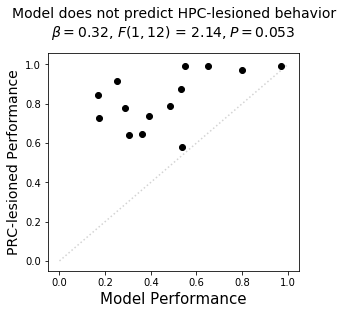

In [15]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=retrospective['hpc_lesion'],x=retrospective[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
hpc_itlayer_fit = smf.ols("hpc_lesion ~ %s"%it_layer, retrospective).fit()
plt.title('Model does not predict HPC-lesioned behavior\n%s'%
          viz.show_model_parameters(hpc_itlayer_fit)[1],
           fontsize=14, y=1.05); 
plt.xlabel('Model Performance', fontsize=15)
plt.ylabel('PRC-lesioned Performance', fontsize=14); 

## An "IT-like" model layer does not predict the behavior of PRC-intact subjects

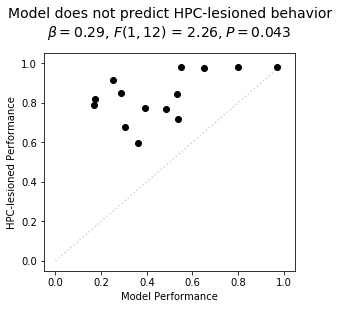

In [16]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=retrospective['prc_intact'],x=retrospective[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
con_itlayer_fit = smf.ols("prc_intact ~ %s"%it_layer, retrospective).fit()
plt.title('Model does not predict HPC-lesioned behavior\n%s'%
          viz.show_model_parameters(con_itlayer_fit)[1],
           fontsize=14, y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance');

### Interaction between PRC-intact and -lesioned subjects

In [17]:
n_experiments = len(retrospective[it_layer])

In [18]:
prcinteraction = smf.ols("human ~ model * group", pandas.DataFrame(
    {'model': np.concatenate((retrospective[it_layer], retrospective[it_layer])), 
     'human': np.concatenate((retrospective['prc_lesion'], retrospective['prc_intact'])),
     'group': np.concatenate([np.repeat('lesion', len(retrospective[it_layer])), 
                              np.repeat('intact', len(retrospective[it_layer]))])
    })).fit()
viz.show_model_parameters(prcinteraction)[0]

$\beta = 0.54$, $F(3, 24)$ = $2.89, P = 0.008 $

### no interaction between hpc-intact and -lesioned subjects

In [19]:
hpcinteraction = smf.ols("human ~ model * group", pandas.DataFrame(
    {'model': np.concatenate((retrospective[it_layer], retrospective[it_layer])), 
     'human': np.concatenate((retrospective['hpc_lesion'], retrospective['hpc_intact'])),
     'group': np.concatenate([np.repeat('lesion', len(retrospective[it_layer])), 
                              np.repeat('intact', len(retrospective[it_layer]))])
    })).fit()
viz.show_model_parameters(hpcinteraction)[0]

$\beta = 0.02$, $F(3, 24)$ = $0.12, P = 0.908 $

### PRC-dependence scales with model performance

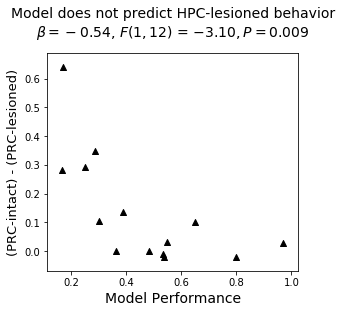

In [20]:
plt.figure(figsize=[4.5, 4])
plt.scatter(x=retrospective[it_layer], y=retrospective['prc_delta'], color='black', marker='^')
linear_dependence = smf.ols('prc_delta ~ %s '%(it_layer), retrospective).fit()
plt.title('Model does not predict HPC-lesioned behavior\n%s'%
          viz.show_model_parameters(linear_dependence)[1],
           fontsize=14, y=1.05); 
plt.ylabel('(PRC-intact) - (PRC-lesioned)', fontsize=13);
plt.xlabel('Model Performance', fontsize=14);

# Figure 2

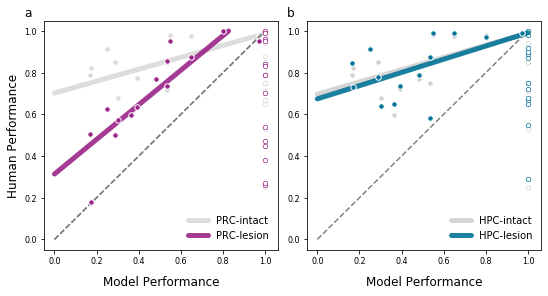

In [21]:
viz.meta_analytic_results(it_layer, retrospective, nondiagnostic) 

# Figure 3

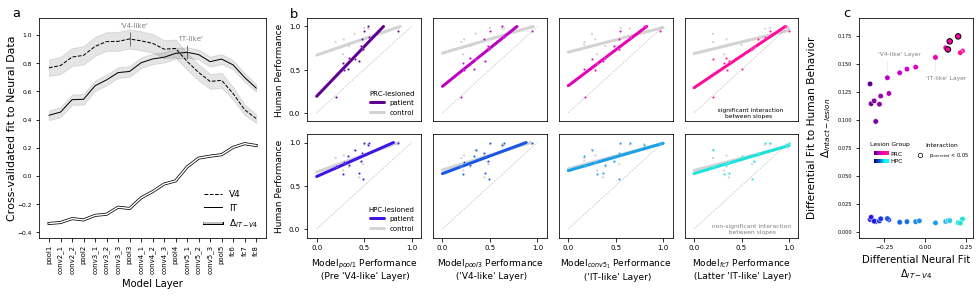

In [22]:
viz.focal_neuroanatomical_dependencies(pls_fits, retrospective, meta_statistics)

# 2.2.1 High-throughput human psychophysics experiments

In [23]:
novel = pandas.read_csv(os.path.join(base_directory, 'high-throughput/human_performance.csv'))

In [24]:
novel_summary = pandas.read_csv(os.path.join(base_directory, 'high-throughput/summary_dataframe.csv'))

### IT outperforms V4

In [25]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_it_v4 ~ 1", novel).fit()
viz.show_model_parameters(novel_itv4_delata)[0]

$\beta = 0.19$, $F(0, 178)$ = $10.33, P = 7 $ x $ 10 ^{-20} $

### PRC outperforms IT

In [26]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_prc_it ~ 1", novel).fit()
viz.show_model_parameters(novel_itv4_delata)[0]

$\beta = 0.24$, $F(0, 178)$ = $14.16, P = 6 $ x $ 10 ^{-31} $

### model predicts IT

In [27]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("it ~ fc6", novel).fit()
viz.show_model_parameters(novel_itv4_delata)[0]

$\beta = 0.63$, $F(1, 177)$ = $11.61, P = 2 $ x $ 10 ^{-23} $

### model outperforms V4

In [28]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_fc6_v4 ~ 1", novel).fit()
viz.show_model_parameters(novel_itv4_delata)[0]

$\beta = 0.27$, $F(0, 178)$ = $13.24, P = 3 $ x $ 10 ^{-28} $

### PRC outperforms model

In [29]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_prc_fc6~1", novel).fit()
viz.show_model_parameters(novel_itv4_delata)[0]

$\beta = 0.16$, $F(0, 178)$ = $8.84, P = 9 $ x $ 10 ^{-16} $

In [30]:
n = len(novel)
novel_interaction_data = pandas.DataFrame({
    'accuracy': np.concatenate([novel['v4'], novel['it'], novel['human']]), 
    'vvs_region': np.concatenate([np.repeat('v4', n), np.repeat('it', n), np.repeat('prc', n)]), 
    'model': np.concatenate([novel['fc6'], novel['fc6'], novel['fc6']]), 
})

In [31]:
# test for interaction by region 
novel_interaction_test = smf.ols("accuracy ~ vvs_region * model", novel_interaction_data).fit()
viz.show_model_parameters(novel_interaction_test)[0]

$\beta = -0.42$, $F(5, 531)$ = $-6.85, P = 2 $ x $ 10 ^{-11} $

In [32]:
rt_delta = smf.ols("zscore(it) ~ -1 + zscore(rt)", novel).fit()
viz.show_model_parameters(rt_delta)[0]

$\beta = -0.58$, $F(1, 178)$ = $-9.59, P = 8 $ x $ 10 ^{-18} $

In [33]:
rt_delta = smf.ols("zscore(v4) ~ zscore(rt)-1", novel).fit()
viz.show_model_parameters(rt_delta)[0]

$\beta = -0.26$, $F(1, 178)$ = $-3.61, P = 4 $ x $ 10 ^{-4} $

In [34]:
rt_delta = smf.ols("zscore(delta_prc_it) ~ -1 + zscore(rt)", novel).fit()
viz.show_model_parameters(rt_delta)[0]

$\beta = 0.40$, $F(1, 178)$ = $5.80, P = 3 $ x $ 10 ^{-8} $

In [35]:
rt_delta = smf.ols("zscore(delta_prc_v4) ~ zscore(rt)", novel).fit()
viz.show_model_parameters(rt_delta)[0]

$\beta = -0.08$, $F(1, 177)$ = $-1.05, P = 0.296 $

In [36]:
rt_delta = smf.ols("zscore(delta_prc_fc6) ~ -1 + zscore(rt)", novel).fit()
viz.show_model_parameters(rt_delta)[0]

$\beta = 0.37$, $F(1, 178)$ = $5.33, P = 3 $ x $ 10 ^{-7} $

In [37]:
rt_delta = smf.ols("zscore(delta_prc_fc6) ~ zscore(rt)-1", novel).fit()
viz.show_model_parameters(rt_delta)[0]

$\beta = 0.37$, $F(1, 178)$ = $5.33, P = 3 $ x $ 10 ^{-7} $

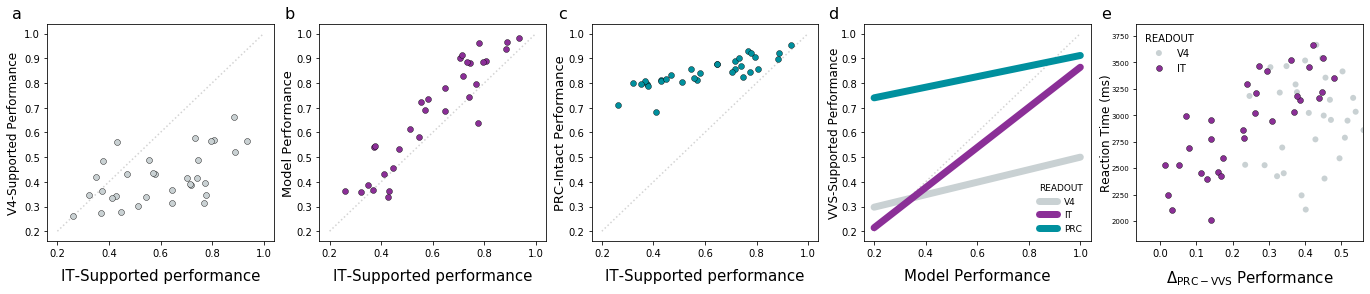

In [38]:
viz.high_throughput_results(novel_summary)

In [39]:
viz.show_model_parameters(novel_interaction_test, -3)[0]

$\beta = 0.63$, $F(5, 531)$ = $14.54, P = 1 $ x $ 10 ^{-40} $

In [40]:
viz.show_model_parameters(novel_interaction_test, -2)[0]

$\beta = -0.47$, $F(5, 531)$ = $-7.68, P = 8 $ x $ 10 ^{-14} $

In [41]:
viz.show_model_parameters(novel_interaction_test)[0]

$\beta = -0.42$, $F(5, 531)$ = $-6.85, P = 2 $ x $ 10 ^{-11} $

# 2.3.1 In Silico Experiments: Model Architecture

In [42]:
resnet_file = os.path.join(base_directory, 'in_silico/architecture/retrospective.pickle')
resnets = pandas.DataFrame({})
with open(resnet_file, 'rb') as handle: 
    _resnets = pickle.load(handle)
    for i_resnet in list(_resnets): 
        resnets['resnet_%s'%i_resnet] = [_resnets[i_resnet][i] for i in retrospective['experiment']]
        retrospective['resnet_%s'%i_resnet] = [_resnets[i_resnet][i] for i in retrospective['experiment']]

In [43]:
model_human_rmse = [( np.sqrt((resnets[i]-retrospective['prc_intact']).mean()**2)) for i in resnets]

In [44]:
viz.show_model_parameters(smf.ols('y ~ x-1', data=pandas.DataFrame(
    {'x':zscore(model_human_rmse),'y': zscore(np.arange(len(model_human_rmse)))})).fit() )[0]

$\beta = -0.55$, $F(1, 4)$ = $-1.33, P = 0.255 $

### All model depths demonstrate a significant interaction between PRC-lesioned and -intact subjects

In [45]:
resnet_test = pandas.DataFrame()
counter = 0
for i_resnet in list(resnets): 
    for i_group in ['prc_intact', 'prc_lesion']: 
        _df = pandas.DataFrame({'resnet':resnets[i_resnet], 
                                'group':np.repeat([0,1][i_group=='prc_intact'], len(retrospective)),
                                'human':retrospective[i_group],
                                'counter': np.repeat(counter, len(retrospective)), 
                                'layers': np.repeat(i_resnet[i_resnet.find('_')+1:], len(retrospective))})
        resnet_test = pandas.concat([resnet_test, _df], ignore_index=True)
    counter += 1

In [46]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.layers=='18']).fit()
viz.show_model_parameters(_restest)[0]

$\beta = -0.51$, $F(3, 24)$ = $-3.32, P = 0.003 $

In [47]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.layers=='34']).fit()
viz.show_model_parameters(_restest)[0]

$\beta = -0.45$, $F(3, 24)$ = $-3.07, P = 0.005 $

In [48]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.layers=='50']).fit()
viz.show_model_parameters(_restest) [0]

$\beta = -0.49$, $F(3, 24)$ = $-3.25, P = 0.003 $

In [49]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.layers=='101']).fit()
viz.show_model_parameters(_restest) [0]

$\beta = -0.56$, $F(3, 24)$ = $-3.66, P = 0.001 $

In [50]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.layers=='152']).fit()
viz.show_model_parameters(_restest) [0]

$\beta = -0.54$, $F(3, 24)$ = $-3.97, P = 6 $ x $ 10 ^{-4} $

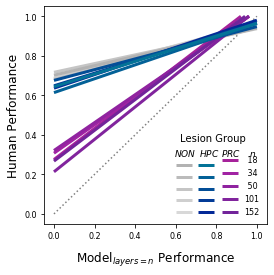

In [51]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)
viz.show_resnets(retrospective)

# 2.3.1 In Silico Experiments: Training Distributions

In [52]:
face_retrospective = os.path.join(base_directory, 'in_silico/training/retrospective/facetrained_retrospective.pickle')

with open(face_retrospective, 'rb') as handle: 
    vgg_face = pickle.load(handle)
    retrospective['vggface'] = [vgg_face[i] for i in retrospective.experiment.values]
    retrospective['isface'] = ['face' in i for i in retrospective.experiment.values]

In [53]:
meta_face = retrospective[retrospective['isface']]
meta_objects = retrospective[retrospective['isface']==False]

In [54]:
_novel = pandas.read_csv('/Users/biota/work/perirhinal_cortex/tasks/analysis/human-model-performance.csv')

In [55]:
mm_path = os.path.join(base_directory, 'in_silico/training/novel/multiple_models_novel_stimuli.csv')
mm_all_markers = pandas.read_csv(mm_path)
mm_select = mm = mm_all_markers[[i in novel['marker'].values for i in mm_all_markers.trial_id]]

imagenet_novel = mm[(mm.model=='vgg16')*(mm.training_data=='imagenet')*(mm.image_type=='foveated')]
novel['imagenet'] = [imagenet_novel[imagenet_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

vggface_novel = mm[(mm.model=='vgg16')*(mm.training_data=='vggface')*(mm.image_type=='foveated')]
novel['vggface'] = [vggface_novel[vggface_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

imagenet_novel = mm[(mm.model=='vgg16')*(mm.training_data=='imagenet')*(mm.image_type=='original')]
novel['imagenet_orig'] = [imagenet_novel[imagenet_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

vggface_novel = mm[(mm.model=='vgg16')*(mm.training_data=='vggface')*(mm.image_type=='original')]
novel['vggface_orig'] = [vggface_novel[vggface_novel.trial_id == i].accuracy.values[0] for i in novel['marker']]

In [56]:
novel_faces = novel[ novel.category == 'faces' ] 
novel_objects = novel[ novel.category != 'faces' ] 

### Faces are "complex": PRC-intact subjects outperform -lesioned subjects, models, and IT

###  meta-analysis

In [57]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data=pandas.DataFrame({'d':meta_face['prc_intact']-meta_face['prc_lesion']})).fit())[0]

$\beta = 0.20$, $F(0, 3)$ = $4.25, P = 0.024 $

In [58]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data=pandas.DataFrame({'d':meta_face['prc_intact']-meta_face['fc6']})).fit())[0]

$\beta = 0.49$, $F(0, 3)$ = $7.99, P = 0.004 $

### novel-analysis

In [59]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data = pandas.DataFrame({'d':novel_faces['human']-novel_faces['imagenet']})).fit())[0]

$\beta = 0.35$, $F(0, 41)$ = $14.04, P = 3 $ x $ 10 ^{-17} $

In [60]:
viz.show_model_parameters(smf.ols(formula = 'delta ~ 1', 
                              data = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['it']})).fit())[0]

$\beta = 0.41$, $F(0, 41)$ = $15.36, P = 1 $ x $ 10 ^{-18} $

### face training increases performance on faces

In [61]:
viz.show_model_parameters(smf.ols(formula = 'delta ~ 1', 
                              data=pandas.DataFrame({'delta':meta_face['vggface']-meta_face['fc6']})).fit())[0]

$\beta = 0.33$, $F(0, 3)$ = $5.14, P = 0.014 $

In [62]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data=pandas.DataFrame({'d':novel_faces['vggface']-novel_faces['imagenet']})).fit())[0]

$\beta = 0.33$, $F(0, 41)$ = $10.53, P = 3 $ x $ 10 ^{-13} $

### Model Performance is statistically indistinguishable for PRC-intact behavior

In [63]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data=pandas.DataFrame({'d':meta_face['prc_intact']-meta_face['vggface']})).fit())[0]

$\beta = 0.16$, $F(0, 3)$ = $1.91, P = 0.153 $

In [64]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data=pandas.DataFrame({'d':novel_faces['human']-novel_faces['vggface']})).fit())[0]

$\beta = 0.03$, $F(0, 41)$ = $0.91, P = 0.369 $

### face-trained models perform worse on non-faces

In [65]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1', 
                              data=pandas.DataFrame({'d':meta_objects['vggface']-meta_objects['fc6']})).fit())[0]

$\beta = -0.14$, $F(0, 9)$ = $-2.63, P = 0.027 $

In [66]:
viz.show_model_parameters(smf.ols(formula = 'd ~ 1',
   data=pandas.DataFrame({'d':novel_objects['vggface']-novel_objects['imagenet']})).fit())[0]

$\beta = -0.15$, $F(0, 136)$ = $-7.30, P = 2 $ x $ 10 ^{-11} $

### significant interaction between training and testing performance, as a function of stimulus type

In [67]:
retro_test = pandas.DataFrame(
    {'human': np.array([retrospective['prc_lesion'], retrospective['prc_lesion']]).flatten(), 
     'model': np.array([retrospective['vggface'], retrospective['fc6']]).flatten(), 
     'face': np.array([retrospective.isface==False, retrospective.isface==False]).flatten(), 
     'type': np.array([np.repeat(0, len(retrospective)), np.repeat(1, len(retrospective))]).flatten()})

novel_test = pandas.DataFrame({
    'human': np.array([novel['human'], novel['human']]).flatten(), 
    'model': np.array([novel['vggface'], novel['imagenet']]).flatten(), 
    'face': np.array([novel.category=='faces', novel.category=='faces']).flatten(), 
    'type': np.array([np.repeat(0, len(novel)), np.repeat(1, len(novel))]).flatten()})

In [68]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=retro_test).fit()
viz.show_model_parameters(_ttestface)[0]

$\beta = 0.47$, $F(3, 24)$ = $2.68, P = 0.013 $

In [69]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=novel_test).fit()
viz.show_model_parameters(_ttestface)[0]

$\beta = -0.48$, $F(3, 354)$ = $-8.99, P = 1 $ x $ 10 ^{-17} $

In [70]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=novel_test).fit()
viz.show_model_parameters(_ttestface)[0]

$\beta = -0.48$, $F(3, 354)$ = $-8.99, P = 1 $ x $ 10 ^{-17} $

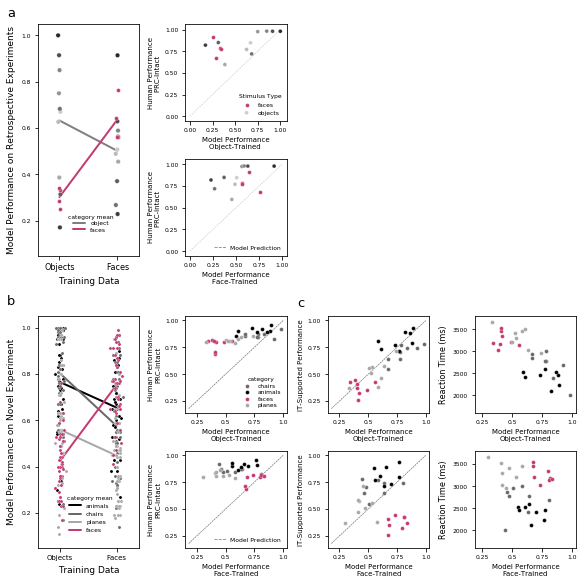

In [71]:
viz.changing_distribution_of_training_data(retrospective, mm_select, novel)

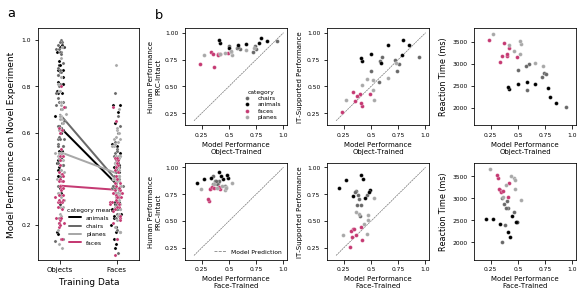

In [72]:
viz.unfoveated_model_behavior(retrospective, mm_select, novel)